# Two approaches in dealing with uncertainty
A Bayesian and Frequentist approach to prediction uncertainty. In both cases, I want to define both aleatoric and epistemic uncertainty.

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

from src.data import generate_dataset
from src.visualization import beautify_ax
from src.models import (
    ModelTrainer, BayesianLinearRegression, 
    QuantileRegressionMCDropoutNet, HeteroscedasticMCDropoutNet
)
from src.models.quantile_utils import create_quantiles

%load_ext autoreload
%autoreload 2

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import logging
logging.basicConfig(level=logging.INFO)

## Generating data

In [3]:
np.random.seed(42)
x, x_test, y, y_test = generate_dataset(n=500, test_size=.2)

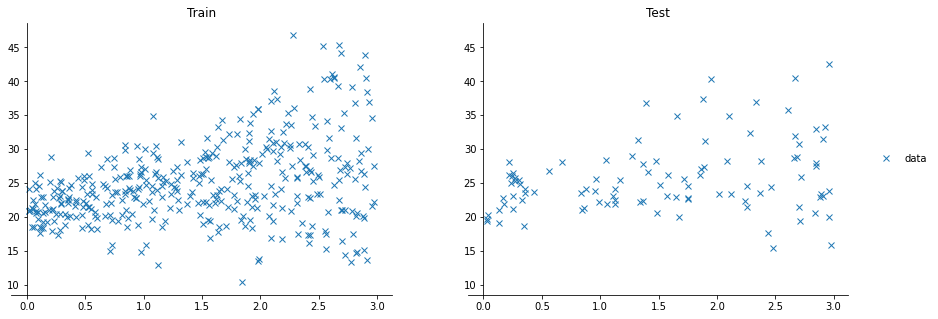

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

axes[0] = beautify_ax(axes[0])
axes[0].plot(x, y, 'x', label='data')
axes[0].set_title("Train")

axes[1] = beautify_ax(axes[1])
axes[1].plot(x_test, y_test, 'x', label='data')
axes[1].set_title("Test")

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## Create our `ModelTrainer` with all models we would like to compare
- `QuantileRegressionMCDropoutNet` (more info, check notebook: '1.0_deep_quantile_regression.ipynb')
- `BayesianLinearRegression` (more info, check notebook: '1.1_bayesian_linear_regression.ipynb')
- `HeteroscedasticMCDropoutNet` (more info, check notebook: '1.2_heteroscedastic_mcdropout.ipynb')

In [5]:
QUANTILES = create_quantiles(11, min_q=0.01, max_q=0.99)
QRMCDN_params = {'input_size': 1, 'hidden_size': 128, 'dropout_p': 0.2, 'quantiles': QUANTILES, 'dropout_dim': 1}
HMCDN_params  = {'input_size': 1, 'hidden_size': 256, 'dropout_p': 0.2}
BLR_params    = {'input_size': 1}

models = {
    "QRMCDN": QuantileRegressionMCDropoutNet(QRMCDN_params),
    "HMCDN": HeteroscedasticMCDropoutNet(HMCDN_params),
    "BLR": BayesianLinearRegression(BLR_params)
}

trainer = ModelTrainer(models, model_path='../models/')

## Make the `trainer` train!

In [6]:
fit_kwargs = {
    "QRMCDN": {'batch_size': 128, 'epochs': 2001, 'print_iter': 100, 'lr': 1e-4},
    "HMCDN": {'batch_size': 16, 'epochs': 2001, 'print_iter': 100, 'lr': 1e-4, 'weight_decay': 1e-6}
}

save_kwargs = {
    "BLR": {'overwrite': True}
}
trainer.train(x, y, fit_kwargs, save_kwargs)

INFO:src.models.model_trainer:Start training QRMCDN
INFO:src.models.model_trainer:Done training QRMCDN and saved to file.
INFO:src.models.model_trainer:Start training HMCDN
INFO:src.models.model_trainer:Done training HMCDN and saved to file.
INFO:src.models.model_trainer:Start training BLR
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_bias, sd_scale, beta, alpha]
INFO:pymc3:NUTS: [sd_bias, sd_scale, beta, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:26<00:00, 151.60draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.87901778836887, but should be clos

## First, generating quantile predictions

Compare the quantile output of the `QuantileRegressionMCDropoutNet` with the derived quantile output from the `BayesianLinearRegression` and the `HeteroscedasticMCDropoutNet.

In [7]:
predict_kwargs = {"BLR": {'quantiles': QUANTILES},
                  "HMCDN": {'quantiles': QUANTILES}}

qpreds = trainer.generate_quantile_predictions(x_test, predict_kwargs)

print(*(f'{name}: {output.shape}' for name, output in qpreds.items()))

INFO:src.models.model_trainer:Start predicting using model: QRMCDN
INFO:src.models.model_trainer:Done predicting.
INFO:src.models.model_trainer:Start predicting using model: HMCDN
INFO:src.models.model_trainer:Done predicting.
INFO:src.models.model_trainer:Start predicting using model: BLR
100%|██████████| 2000/2000 [00:28<00:00, 70.44it/s]
INFO:src.models.model_trainer:Done predicting.


QRMCDN: (100, 11) HMCDN: (100, 11) BLR: (100, 11)


### Selecting some random test cases

In [8]:
random_is = np.random.randint(0, len(x_test), 9)

### Plotting the quantile predictions

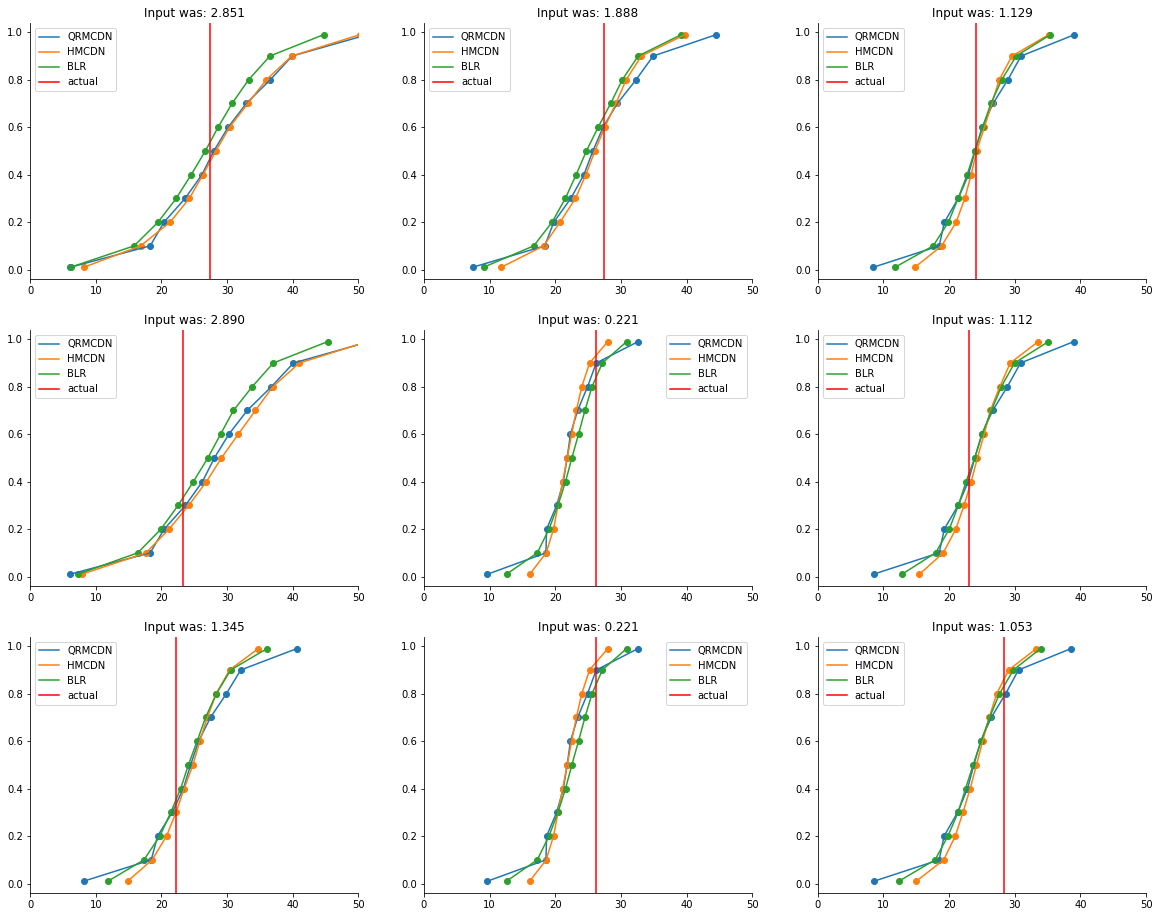

In [9]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    
    for m_name, preds in qpreds.items():
        ax.plot(preds[i], QUANTILES, label=m_name)
        ax.scatter(preds[i], QUANTILES)

    ax.axvline(y_test[i], c='r', label='actual')
    ax.set_title(f"Input was: {x_test[i][0]:.3f}")
    ax.legend()
    ax.set_xlim(0, 50)

plt.show()

## Secondly, generating distributions

The other way around. Create an approximate posterior distribution from the output of the `QuantileRegressionMCDropoutNet`. Then we can compare it with the output from the `BayesianLinearRegression` and the `HeteroscedasticMCDropoutNet.

In [10]:
posterior_samples = trainer.generate_posterior_samples(x_test, sample_kwargs={'BLR': {'samples': 1000}})

print(*(f'{name}: {output.shape}' for name, output in posterior_samples.items()))

INFO:src.models.model_trainer:Start predicting using model: QRMCDN
INFO:src.models.model_trainer:Done predicting.
INFO:src.models.model_trainer:Start predicting using model: HMCDN
INFO:src.models.model_trainer:Done predicting.
INFO:src.models.model_trainer:Start predicting using model: BLR
100%|██████████| 1000/1000 [00:15<00:00, 63.98it/s]
INFO:src.models.model_trainer:Done predicting.


QRMCDN: (100, 1000) HMCDN: (100, 1000) BLR: (100, 1000)


### Plotting the approximate posterior distributions

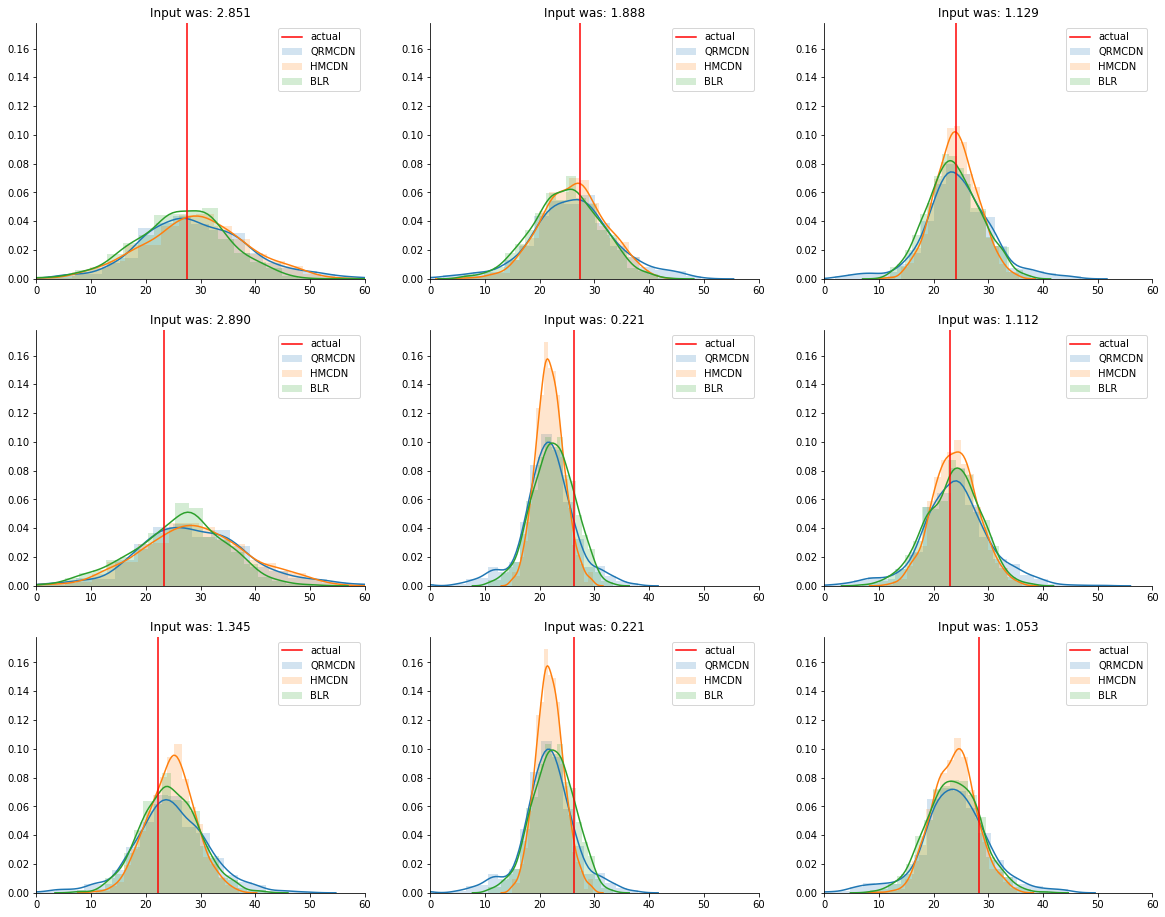

In [11]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    
    for m_name, samples in posterior_samples.items():
        sns.distplot(samples[i], bins=20, label=m_name, hist_kws={'alpha':0.2}, ax=ax)
    
    ax.set_title(f"Input was: {x_test[i][0]:.3f}")
    ax.axvline(y_test[i], c='r', label='actual')
    ax.legend()
    ax.set_xlim(0, 60)
    
plt.show()

The point estimates predictions are really similar!

In [12]:
for m_name, preds in qpreds.items():
    error = mean_absolute_error(y_test, np.mean(preds, axis=1))
    print(f"MAE - {m_name}\t: {error:.3f}")

MAE - QRMCDN	: 3.867
MAE - HMCDN	: 3.896
MAE - BLR	: 3.822
